In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import nltk
nltk.download('punkt_tab')
import pandas as pd

# Example for a CSV file
dataset = pd.read_csv('/content/drive/My Drive/messages.csv')

import numpy as np        # For numerical operations
import pandas as pd       # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
%matplotlib inline

# Importing WordCloud for text visualization
from wordcloud import WordCloud

# Importing NLTK for natural language processing
import nltk
from nltk.corpus import stopwords    # For stopwords


# Downloading NLTK data
nltk.download('stopwords')   # Downloading stopwords data
nltk.download('punkt')

dataset.info()

df = dataset.drop('subject', axis=1)
df

df = df.drop_duplicates(keep = 'first')



# Define features and target variable
emails = df['message']
labels = df['label']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from typing import Tuple, List

class CompetitiveCoevolutionGA:
    def __init__(self, n_individuals: int, dim: int):
        self.n_individuals = self._next_power_of_2(n_individuals)
        self.dim = dim
        self.population = np.random.choice([0, 1], size=(self.n_individuals, dim), p=[0.7, 0.3])
        self.fitness_scores = np.zeros(self.n_individuals)
        self.tournament_history: List[List[Tuple[int, int, int]]] = []  # [(winner, loser, round)]
        self.best_solution = None
        self.best_fitness = -np.inf

    def _next_power_of_2(self, x: int) -> int:
        return 1 if x == 0 else 2**(x - 1).bit_length()

    def evaluate_solution(self, features: np.ndarray, X_train: np.ndarray,
                         X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> float:
        selected_features = features.astype(bool)
        n_selected = np.sum(selected_features)

        if n_selected < 2 or n_selected > X_train.shape[1] // 2:
            return 0.0

        try:
            selected_train = X_train[:, selected_features]
            selected_test = X_test[:, selected_features]

            model = LinearSVC(dual=False, max_iter=2000, random_state=42)
            model.fit(selected_train, y_train)
            predictions = model.predict(selected_test)
            accuracy = accuracy_score(y_test, predictions)

            # Balanced fitness function
            feature_ratio = n_selected / X_train.shape[1]
            complexity_penalty = 0.001 * feature_ratio
            diversity_bonus = 0.001 * (1 - self._solution_similarity_to_best(features))

            return accuracy - complexity_penalty + diversity_bonus

        except Exception as e:
            print(f"Error in evaluation: {e}")
            return 0.0

    def _solution_similarity_to_best(self, solution: np.ndarray) -> float:
        if self.best_solution is None:
            return 0.0
        return np.mean(solution == self.best_solution)

    def single_elimination_tournament(self, X_train: np.ndarray, X_test: np.ndarray,
                                   y_train: np.ndarray, y_test: np.ndarray) -> None:
        # Reset tournament history for this generation
        self.tournament_history = []
        round_matches: List[Tuple[int, int, int]] = []

        # Initialize tournament brackets
        indices = np.arange(self.n_individuals)
        np.random.shuffle(indices)
        current_round = 0

        while len(indices) > 1:
            next_round_indices = []
            round_matches = []

            for i in range(0, len(indices), 2):
                p1_idx, p2_idx = indices[i], indices[i + 1]

                # Evaluate both solutions
                p1_score = self.evaluate_solution(self.population[p1_idx],
                                               X_train, X_test, y_train, y_test)
                p2_score = self.evaluate_solution(self.population[p2_idx],
                                               X_train, X_test, y_train, y_test)

                # Determine winner and record match result
                if p1_score > p2_score:
                    next_round_indices.append(p1_idx)
                    round_matches.append((p1_idx, p2_idx, current_round))
                else:
                    next_round_indices.append(p2_idx)
                    round_matches.append((p2_idx, p1_idx, current_round))

            self.tournament_history.append(round_matches)
            indices = next_round_indices
            current_round += 1

        # Calculate relative fitness based on tournament performance
        self._calculate_tournament_fitness()

        # Update best solution
        winner_idx = indices[0]
        winner_score = self.evaluate_solution(self.population[winner_idx],
                                           X_train, X_test, y_train, y_test)

        if winner_score > self.best_fitness:
            self.best_solution = self.population[winner_idx].copy()
            self.best_fitness = winner_score

    def _calculate_tournament_fitness(self) -> None:
        # Initialize base fitness values
        self.fitness_scores = np.zeros(self.n_individuals)

        # Award points based on tournament performance
        for round_num, round_matches in enumerate(self.tournament_history):
            round_weight = 2 ** round_num  # Higher rounds worth more
            for winner, loser, _ in round_matches:
                self.fitness_scores[winner] += round_weight
                self.fitness_scores[loser] += round_weight * 0.5  # Consolation points

        # Normalize fitness scores
        if np.max(self.fitness_scores) > 0:
            self.fitness_scores = self.fitness_scores / np.max(self.fitness_scores)

    def breed(self) -> np.ndarray:
        # Tournament selection for breeding
        offspring = np.zeros_like(self.population)

        for i in range(len(offspring)):
            # Select parents using tournament selection
            parent1_idx = self._tournament_selection(3)  # Tournament size of 3
            parent2_idx = self._tournament_selection(3)

            # Uniform crossover
            mask = np.random.rand(self.dim) < 0.5
            offspring[i] = np.where(mask, self.population[parent1_idx],
                                  self.population[parent2_idx])

            # Mutation
            mutation_rate = 0.1 * (1 - self.fitness_scores[i])  # Adaptive mutation
            mutation_mask = np.random.rand(self.dim) < mutation_rate
            offspring[i] = np.where(mutation_mask, 1 - offspring[i], offspring[i])

            # Ensure minimum features
            if np.sum(offspring[i]) < 2:
                random_features = np.random.choice(self.dim, 2, replace=False)
                offspring[i][random_features] = 1

        return offspring

    def _tournament_selection(self, tournament_size: int) -> int:
        candidates = np.random.choice(self.n_individuals, tournament_size, replace=False)
        return candidates[np.argmax(self.fitness_scores[candidates])]

    def optimize(self, X_train: np.ndarray, X_test: np.ndarray,
                y_train: np.ndarray, y_test: np.ndarray,
                max_generations: int = 100) -> Tuple[np.ndarray, float]:
        for generation in range(max_generations):
            # Competitive fitness assessment
            self.single_elimination_tournament(X_train, X_test, y_train, y_test)

            # Breeding and population update
            offspring = self.breed()

            # Generational replacement with elitism
            elite_size = self.n_individuals // 4
            elite_indices = np.argsort(self.fitness_scores)[-elite_size:]

            new_population = np.zeros_like(self.population)
            new_population[:elite_size] = self.population[elite_indices]
            new_population[elite_size:] = offspring[:-elite_size]

            self.population = new_population

            print(f"Generation {generation}: Best fitness = {self.best_fitness:.4f}")

        return self.best_solution, self.best_fitness

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Generation 0: Best fitness = 0.9928
Generation 1: Best fitness = 0.9929
Generation 2: Best fitness = 0.9929
Generation 3: Best fitness = 0.9957
Generation 4: Best fitness = 0.9957
Generation 5: Best fitness = 0.9964
Generation 6: Best fitness = 0.9973
Generation 7: Best fitness = 0.9973
Generation 8: Best fitness = 0.9973
Generation 9: Best fitness = 0.9973
Generation 10: Best fitness = 0.9973
Generation 11: Best fitness = 0.9973
Generation 12: Best fitness = 0.9973
Generation 13: Best fitness = 0.9973
Generation 14: Best fitness = 0.9982
Generation 15: Best fitness = 0.9982
Generation 16: Best fitness = 0.9982
Generation 17: Best fitness = 0.9982
Generation 18: Best fitness = 0.9982
Generation 19: Best fitness = 0.9982
Generation 20: Best fitness = 0.9990
Generation 21: Best fitness = 0.9991
Generation 22: Best fitness = 0.9991
Generation 23: Best fitness = 0.9991
Generation 24: Best fitness = 0.9991
Generation 25: Best fitness = 0.9991
Generation 26: Best fitness = 0.9991
Generation 

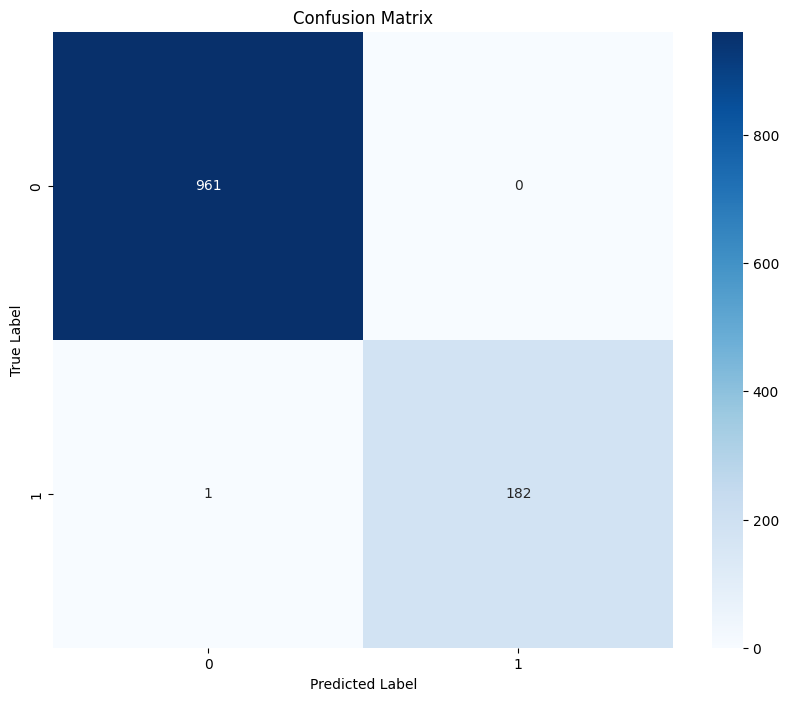

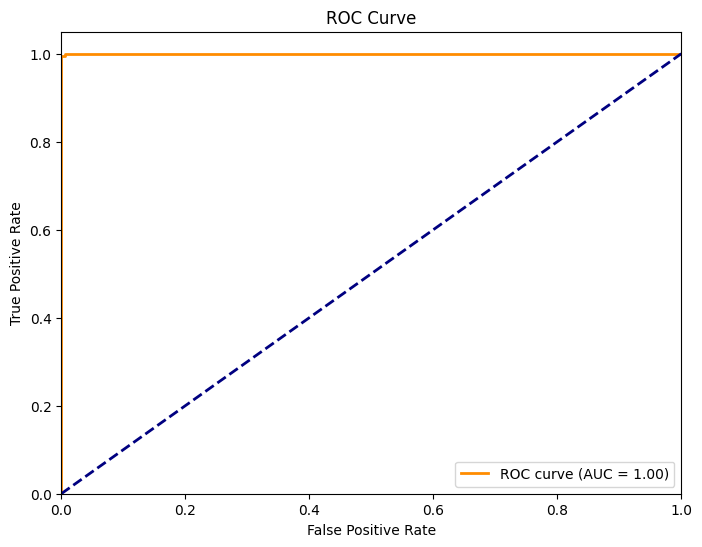

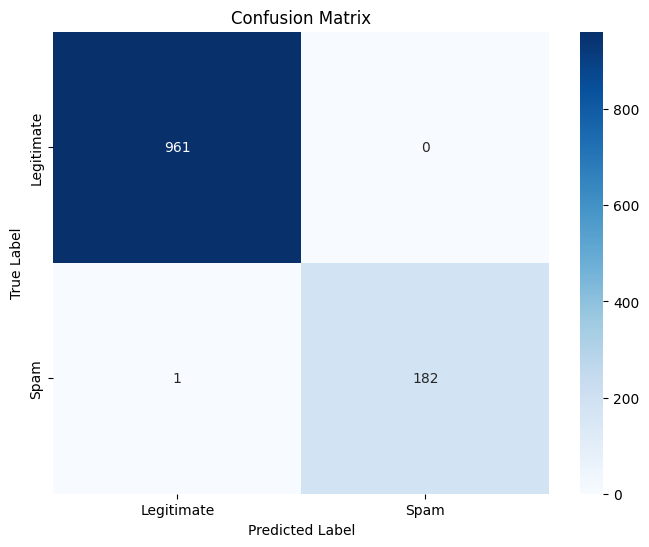

In [ ]:
import nltk
from nltk.corpus import wordnet
import random
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

class EmailFeatureEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test, vectorizer, label_encoder):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.vectorizer = vectorizer
        self.label_encoder = label_encoder

    def evaluate_features(self, selected_features):
        X_train_selected = self.X_train[:, selected_features]
        X_test_selected = self.X_test[:, selected_features]

        model = LinearSVC(dual=False, max_iter=2000, random_state=42)
        model.fit(X_train_selected, self.y_train)

        y_pred = model.predict(X_test_selected)
        y_score = model.decision_function(X_test_selected)

        original_labels = self.label_encoder.inverse_transform(np.unique(self.y_test))
        conf_matrix = confusion_matrix(self.y_test, y_pred)
        class_report = classification_report(self.y_test, y_pred,
                                          target_names=original_labels,
                                          output_dict=True)

        fpr, tpr, roc_auc = None, None, None
        if len(original_labels) == 2:
            fpr, tpr, _ = roc_curve(self.y_test, y_score)
            roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=original_labels,
                    yticklabels=original_labels)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        conf_matrix_plot = plt.gcf()

        if len(original_labels) == 2:
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2,
                     label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc="lower right")
            roc_plot = plt.gcf()
        else:
            roc_plot = None

        feature_names = self.vectorizer.get_feature_names_out()
        selected_feature_names = feature_names[selected_features]
        feature_importance = np.abs(model.coef_[0]) if len(original_labels) == 2 else np.mean(np.abs(model.coef_), axis=0)
        feature_importance_dict = dict(zip(selected_feature_names, feature_importance))
        sorted_features = dict(sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True))

        return {
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'roc_auc': roc_auc,
            'confusion_matrix_plot': conf_matrix_plot,
            'roc_plot': roc_plot,
            'feature_importance': sorted_features,
            'n_selected_features': np.sum(selected_features),
            'model': model
        }

def clean_text(text):
    if not isinstance(text, str):
        return str(text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return ' '.join(text.split()) or 'empty_message'

def prepare_email_data_adversarial(emails, labels, max_features=1000, test_size=0.2, random_state=42):
    nltk.download('wordnet')
    nltk.download('punkt')

    def generate_adversarial_text(text):
        text = clean_text(text)
        words = nltk.word_tokenize(text)
        if not words:
            return text

        perturbed_words = []
        for word in words:
            if random.random() < 0.2 and len(word) > 3:
                synonyms = wordnet.synsets(word)
                if synonyms and synonyms[0].lemmas():
                    synonym = synonyms[0].lemmas()[0].name()
                    perturbed_words.append(synonym if synonym != word else word)
                else:
                    perturbed_words.append(word)
            else:
                perturbed_words.append(word)
        return ' '.join(perturbed_words)

    messages = emails.tolist() if isinstance(emails, pd.Series) else list(emails)
    labels_list = labels.tolist() if isinstance(labels, pd.Series) else list(labels)

    cleaned_texts = [clean_text(text) for text in messages]
    adversarial_texts = [generate_adversarial_text(text) for text in cleaned_texts]

    combined_texts = cleaned_texts + adversarial_texts
    combined_labels = labels_list + labels_list

    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words=None,
        min_df=1,
        max_df=1.0,
        strip_accents='unicode',
        lowercase=True,
        token_pattern=r'\b\w+\b'
    )

    X = vectorizer.fit_transform(combined_texts).toarray()

    le = LabelEncoder()
    y = le.fit_transform(combined_labels)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_test, y_train, y_test, vectorizer, le

def run_complete_pipeline_adversarial(emails, labels):
    X_train, X_test, y_train, y_test, vectorizer, le = prepare_email_data_adversarial(emails, labels)

    GA = CompetitiveCoevolutionGA(n_individuals=32, dim=X_train.shape[1])
    best_features, best_fitness = GA.optimize(X_train, X_test, y_train, y_test)

    evaluator = EmailFeatureEvaluator(X_train, X_test, y_train, y_test, vectorizer, le)
    results = evaluator.evaluate_features(best_features.astype(bool))

    print("\n=== Email Classification Results ===")
    print(f"Selected Features: {results['n_selected_features']}")
    print(f"Best Fitness Score: {best_fitness:.4f}")

    # Get metrics for each class (Legitimate and Spam)
    print("\n=== Per-Class Performance ===")

    # Handle class labels safely
    class_labels = [label for label in results['classification_report'].keys()
                   if label not in ['accuracy', 'macro avg', 'weighted avg']]

    for label in class_labels:
        metrics = results['classification_report'][label]
        class_name = "Legitimate Email" if str(label) == '0' else "Spam Email"
        print(f"\n{class_name} Metrics:")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']} samples")

    # Print overall metrics
    print("\n=== Overall Performance ===")
    print(f"Accuracy: {results['classification_report']['accuracy']:.4f}")

    # Print weighted average metrics
    weighted_avg = results['classification_report']['weighted avg']
    print("\n=== Weighted Average Metrics ===")
    print(f"Weighted Precision: {weighted_avg['precision']:.4f}")
    print(f"Weighted Recall: {weighted_avg['recall']:.4f}")
    print(f"Weighted F1-score: {weighted_avg['f1-score']:.4f}")

    # Add confusion matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Spam'],
                yticklabels=['Legitimate', 'Spam'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return results

if __name__ == "__main__":
    results = run_complete_pipeline_adversarial(emails, labels)